In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# **Data Importing**

In [11]:
trainData = pd.read_csv('/kaggle/input/titanic/train.csv')
testData = pd.read_csv('/kaggle/input/titanic/test.csv')
genderSubmission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# **Basis Statistical Info**

In [12]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [13]:
trainData.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


# **Data Cleaning and Transforming**

In [15]:
# Dropping Irrelevant Columns
X = trainData.drop(labels=['Cabin', 'PassengerId', 'Name', 'Ticket', 'Survived'], axis=1)
y = trainData['Survived']

In [16]:
display(X)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


In [17]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Column Type Selection for Preprocessing
numCols = X.select_dtypes(include=['number']).columns
catCols = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines
numTransformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

catTransformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())
])

preprocessor = ColumnTransformer([
    ("num", numTransformer, numCols),
    ("cat", catTransformer, catCols)
])



In [19]:
prep = Pipeline([
        ("preprocess", preprocessor)
    ])

X = prep.fit_transform(X)

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [20]:
X

array([[ 0.82737724, -0.56573646,  0.43279337, ..., -0.50244517,
         1.        ,  2.        ],
       [-1.56610693,  0.66386103,  0.43279337, ...,  0.78684529,
         0.        ,  0.        ],
       [ 0.82737724, -0.25833709, -0.4745452 , ..., -0.48885426,
         0.        ,  2.        ],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337, ..., -0.17626324,
         0.        ,  2.        ],
       [-1.56610693, -0.25833709, -0.4745452 , ..., -0.04438104,
         1.        ,  0.        ],
       [ 0.82737724,  0.20276197, -0.4745452 , ..., -0.49237783,
         1.        ,  1.        ]])

cuML: 25.02.01
[2025-10-20 20:45:35.582] [CUML] [info] Building knn graph using brute force


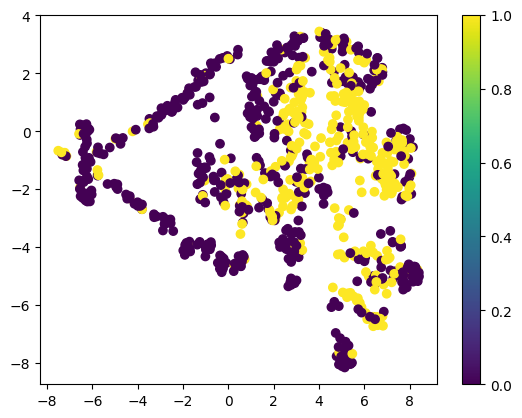

In [35]:
import cuml
print("cuML:", cuml.__version__)

from cuml.manifold import UMAP
import matplotlib.pyplot as plt

umap = UMAP(n_components=2, n_neighbors=100, min_dist=0.5)
Z = umap.fit_transform(X)

plt.scatter(Z[:,0], Z[:,1], c=y)
plt.colorbar()
plt.show()

# **Models Selection and Hyperparams Optimization**

In [9]:
# Models Import
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skopt import BayesSearchCV   # Hyperparams Optimization
from skopt.space import Real, Categorical, Integer

# Models Definition
models = {
    "GaussianNB": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVC": SVC()
}

# Search Spaces for Bayesian Hyperparams Optimization
search_spaces = {
    "QDA": {
        "model__reg_param": Real(0, 1)
        },
    "KNN": {
        "model__n_neighbors": Integer(3, 15)
        },
    "DecisionTree": {
        'model__max_depth': Integer(3, 20),
        'model__min_samples_leaf': Integer(1, 10),
        'model__max_features': Real(0.3, 0.8)
        },
    "RandomForest": {
        'model__n_estimators': Integer(100, 400),
        'model__max_depth': Integer(3, 20),
        'model__min_samples_leaf': Integer(1, 10),
        'model__max_features': Real(0.3, 0.8)
    },
    "SVC": {
        'model__C': Real(1e-3, 10, prior='log-uniform'),
        'model__gamma': Real(1e-4, 1.0, prior='log-uniform'),
        'model__kernel': Categorical(['rbf', 'poly', 'linear'])
    }
}


# **Final Pipeline Execution**

In [52]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Train/Test Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Training and Evaluation Loop
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

results = []

for name, model in models.items():
    print(f"\n=== {name} ===")

    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])

    if name in search_spaces:
        print("Running Bayesian Optimization...")
        opt = BayesSearchCV(
            estimator=pipe,
            search_spaces=search_spaces[name],
            n_iter=25,
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        opt.fit(X_train, y_train)
        best_model = opt.best_estimator_
        best_params = opt.best_params_
        best_cv_score = opt.best_score_
    else:
        print("No hyperparameters to tune — fitting directly.")
        pipe.fit(X_train, y_train)
        best_model = pipe
        best_params = None
        best_cv_score = cross_val_score(pipe, X, y, cv=5, scoring="accuracy").mean()

    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append((name, acc, best_cv_score, best_params))



=== GaussianNB ===
No hyperparameters to tune — fitting directly.

=== LDA ===
No hyperparameters to tune — fitting directly.

=== QDA ===
Running Bayesian Optimization...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
F

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [6] before, using random point [8]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [12] before, using random point [8]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [11] before, using random point [13]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [15] before, using random point [5]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [15] before, using random point [6]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [15] before, using random point [4]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [7] before, using random point [12]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [12] before, using random point [5]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits

=== DecisionTree ===
Running Bayesian Optimization...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
F

In [53]:
# === Display Results ===
results_df = pd.DataFrame(results, columns=["Model", "Test Accuracy", "CV Accuracy", "Best Hyperparams"]).sort_values(by="Test Accuracy", ascending=False)
display(results_df)

,Model,Test Accuracy,CV Accuracy,Best Hyperparams
5,RandomForest,0.810056,0.830149,"{'model__max_depth': 14, 'model__max_features'..."
6,SVC,0.804469,0.827322,"{'model__C': 2.2364202820542705, 'model__gamma..."
1,LDA,0.793296,0.790120,None
4,DecisionTree,0.787709,0.807663,"{'model__max_depth': 20, 'model__max_features'..."
0,GaussianNB,0.782123,0.791269,None
2,QDA,0.776536,0.813257,{'model__reg_param': 0.07783852095039677}
3,KNN,0.770950,0.816084,{'model__n_neighbors': 14}


In [57]:
results[3]

('KNN',
 0.770949720670391,
 0.816083916083916,
 OrderedDict([('model__n_neighbors', 14)]))